# pixels2diagram

In [1]:

    
def spiral(n_cups):
    """
    Implements the asymptotic worst-case for normal_form, see arXiv:1804.07832.
    """
    result = unit
    for i in range(n_cups):
        result = result >> Id(x ** i) @ cap @ Id(x ** (i + 1))
    result = result >> Id(x ** n_cups) @ counit @ Id(x ** n_cups)
    for i in range(n_cups):
        result = result >>\
            Id(x ** (n_cups - i - 1)) @ cup @ Id(x ** (n_cups - i - 1))
    return result

Id(x) @ spider >> Id(x @ x) @ unit @ Id(x) >> spider @ Id(x @ x @ x) >> Id(x @ x) @ cup @ Id(x) >> Id(x) @ counit @ Id(x) >> product


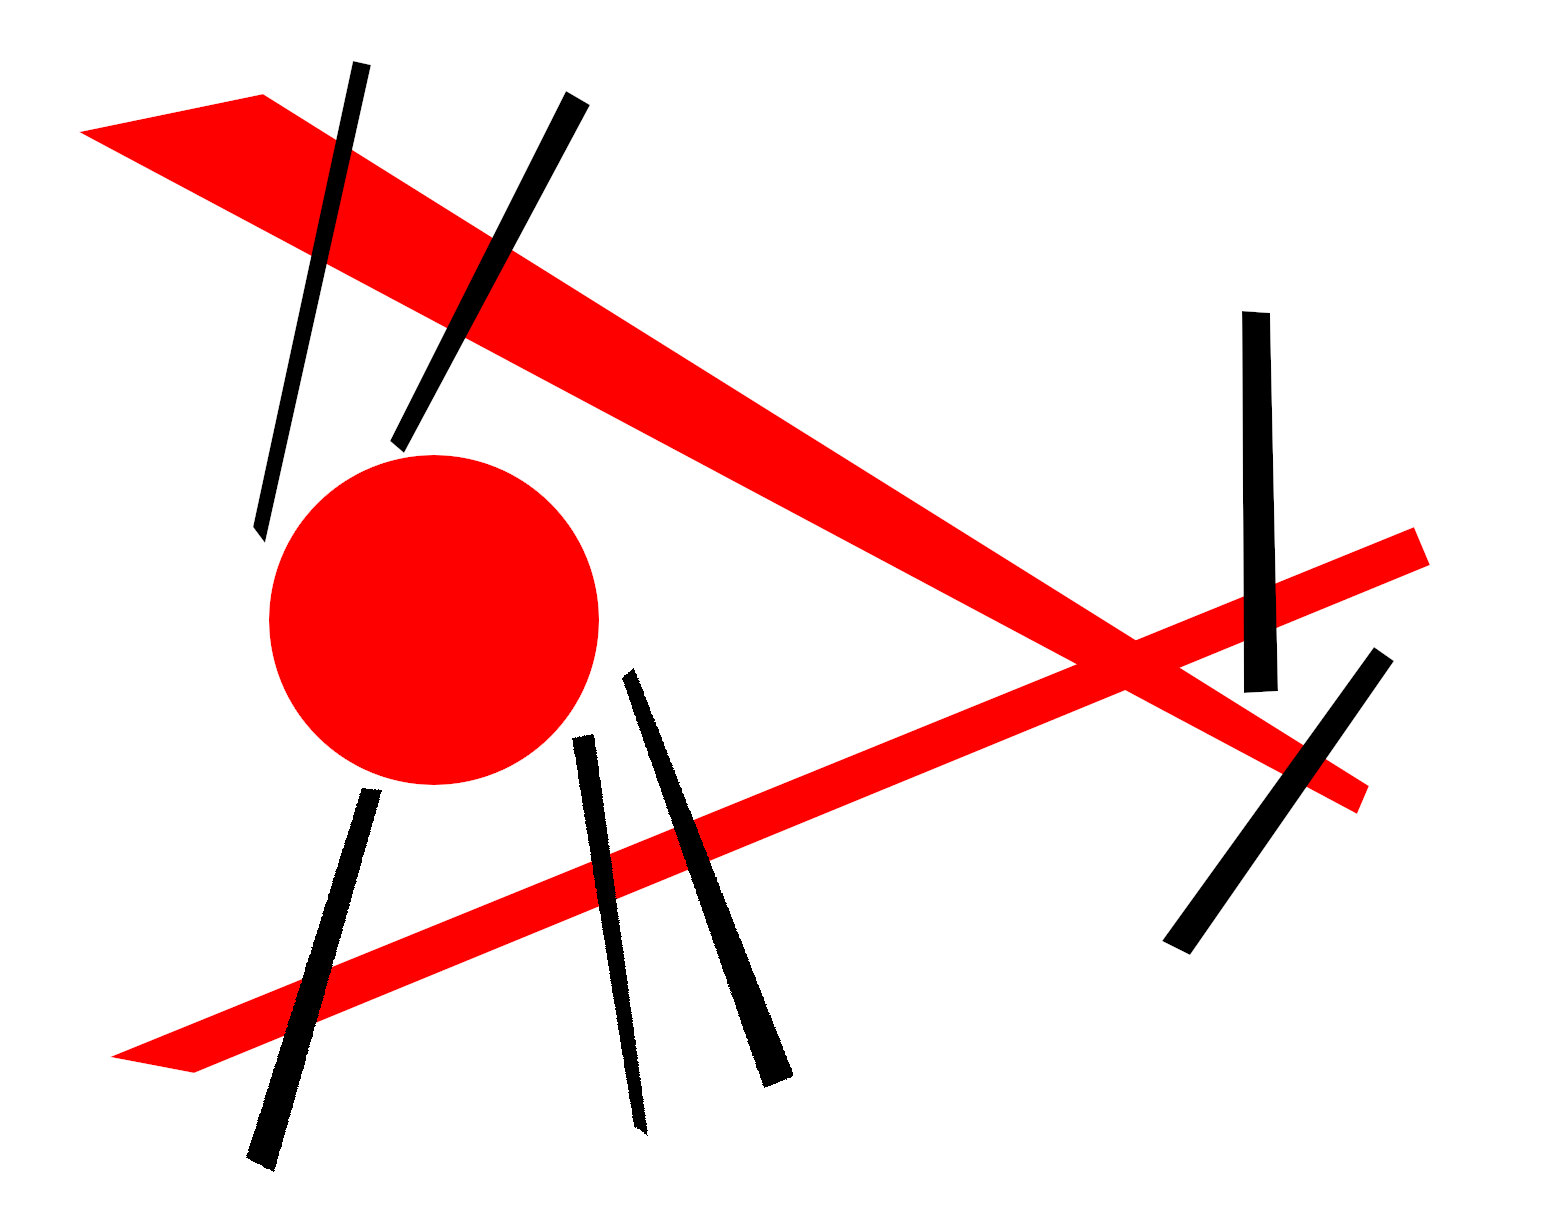

In [2]:
from discopy import *
from PIL import Image

x = Ty('x')
unit, counit = Box('unit', Ty(), x), Box('counit', x, Ty())
cup, cap = Box('cup', x @ x, Ty()), Box('cap', Ty(), x @ x)
product = Box('product', x ** 2, x)
coprod = Box('spider', x, x ** 2)

for box in [unit, counit, cup, cap, product, coprod]:
    box.draw_as_spider, box.color, box.drawing_name = True, "red", ""

diagram = spiral(2)
rewrites = list(diagram.normalize())
diagram = rewrites[10]
diagram = Id(x) @ coprod >> Id(x ** 2) @ unit @ Id(x) >> coprod @ Id(x @ x @ x) >> Id(x @ x) @ cup @ Id(x) >> Id(x) @ counit @ Id(x) >> product

print(diagram)

params = dict(
    draw_type_labels=False,
    draw_as_nodes=True,
    draw_box_labels=False,
    figsize=(10, 10),
    margins=(0, 0),
    nodesize=10,
    linewidth=10,
    path='/Users/alexis.toumi/WORK/TEX/THESIS/img/punkt-und-linie/start.png')

diagram.draw(**params, path='imgs/test-pixels2diagram.png')
img = Image.open('imgs/test-pixels2diagram.png')
img

In [3]:
import numpy as np

arr = np.array(img)
print("height, width, [red, blue, green, opacity]: {}".format(arr.shape))

height, width, [red, blue, green, opacity]: (1229, 1561, 4)


Found 9 boxes:


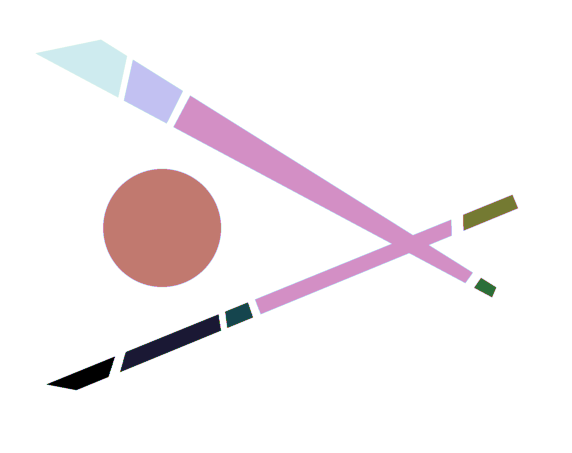

In [4]:
from skimage import measure
from matplotlib import pyplot as plt


threshold = 200
red = np.logical_and(arr[:, :, 0] > threshold,
                     arr[:, :, 1] < threshold,
                     arr[:, :, 2] < threshold)
box_pixels, n_boxes = measure.label(red, return_num=True)
print("Found {} boxes:".format(n_boxes))

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(-box_pixels, cmap='cubehelix')
plt.show()

Found 7 wires:


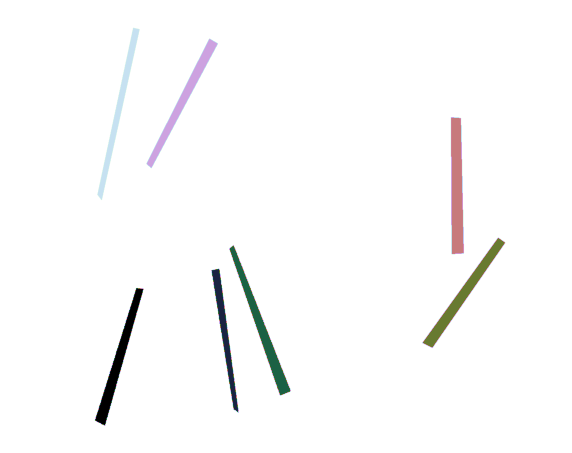

In [5]:
wire_pixels, n_wires = measure.label(arr[:, :, 0] < threshold, return_num=True)
print("Found {} wires:".format(n_wires))

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(-wire_pixels, cmap='cubehelix')

plt.show()

In [6]:

def decode(dom, boxes_and_offsets) -> Diagram:
    result = Diagram.id(dom)
    for box, offset in boxes_and_offsets:
        left, right = result.cod[:offset], result.cod[offset + len(box.dom):]
        result >>= Diagram.id(left) @ box @ Diagram.id(right)
    return result

In [7]:
from numpy import array, argmin
from skimage.measure import regionprops, label

def read(box_pixels: array, wire_pixels: array) -> Diagram:
    connected_components = lambda img: regionprops(label(img))
    box_nodes, wires = map(connected_components, (box_pixels, wire_pixels))
    source, target, length, width = [], [], len(box_pixels), len(box_pixels[0])
    critical_heights = [0] + [int(node.centroid[0]) for node in box_nodes] + [length]
    for wire, region in enumerate(wires):
        top, bottom = (minmax(i for i, _ in region.coords) for minmax in (min, max))
        source.append(argmin(abs(array(critical_heights) - top)))
        target.append(argmin(abs(array(critical_heights) - bottom)))
    for s, t in zip(source, target): print("{} \\to {}".format(s, t))
    scan = [wire for wire, node in enumerate(source) if node == 0]
    dom, boxes_and_offsets = Ty('x') ** len(scan), []
    for depth, box_node in enumerate(box_nodes):
        input_wires = [wire for wire in scan if target[wire] == depth + 1]
        output_wires = [wire for wire, node in enumerate(source) if node == depth + 1]
        print(scan, input_wires, output_wires)
        box = Box('box', Ty('x') ** len(input_wires), Ty('x') ** len(output_wires))
        height, left = map(int, box_node.centroid)
        left_of_box = [wire for wire in scan if wire not in input_wires
                       and dict(wires[wire].coords).get(height, width) < left]
        offset = max(len(left_of_box), 0)
        boxes_and_offsets.append((box, offset))
        scan = scan[:offset] + output_wires + scan[offset + len(input_wires):]
    return decode(dom, boxes_and_offsets)

In [8]:
read(red, wire_pixels).draw(draw_box_labels=False, draw_type_labels=False, to_tikz=True, path='/Users/alexis.toumi/WORK/TEX/THESIS/img/punkt-und-linie/finish.png')

0 \to 3
1 \to 3
2 \to 4
4 \to 8
4 \to 9
6 \to 10
6 \to 10
[0] [] [1]
[1, 0] [] [2]
[1, 2, 0] [1, 0] []
[0] [] [3, 4]
[3, 4, 0] [] []
[3, 4, 0] [] [5, 6]
[3, 4, 5, 6, 0] [] []
[3, 4, 5, 6, 0] [3] []
[3, 5, 6, 0] [] []


In [9]:
box_properties = measure.regionprops(box_pixels)
wire_properties = measure.regionprops(wire_pixels)

critical_heights = np.array(
    [0] + [box['centroid'][0] for box in box_properties] + [arr.shape[0]])

def find_start_and_endpoints(wire):
    start = np.argmin(np.abs(critical_heights - wire['coords'][0][0]))
    end = np.argmin(np.abs(critical_heights - wire['coords'][-1][0]))
    return (start, end)

print("Connectivity (wires to boxes [1, ..., 9] or boundary [0, 10]):")
wires_to_boxes = {i: find_start_and_endpoints(wire) for i, wire in enumerate(wire_properties)}
wires_to_boxes

Connectivity (wires to boxes [1, ..., 9] or boundary [0, 10]):


{0: (0, 3), 1: (1, 3), 2: (2, 4), 3: (4, 8), 4: (4, 9), 5: (6, 10), 6: (6, 10)}

In [10]:
print("Connectivity (boxes/boundary to wires):")
boxes_to_wires = {i: ([wire for wire, (_, end) in wires_to_boxes.items() if end == i],
                      [wire for wire, (start, _) in wires_to_boxes.items() if start == i])
                  for i, _ in enumerate(critical_heights)}
boxes_to_wires

Connectivity (boxes/boundary to wires):


{0: ([], [0]),
 1: ([], [1]),
 2: ([], [2]),
 3: ([0, 1], []),
 4: ([2], [3, 4]),
 5: ([], []),
 6: ([], [5, 6]),
 7: ([], []),
 8: ([3], []),
 9: ([4], []),
 10: ([5, 6], [])}

In [11]:
scan = boxes_to_wires[0][1]
result = Id(PRO(len(scan)))
for i, box_data in enumerate(box_properties):
    inputs, outputs = boxes_to_wires[i + 1]
    depth, width = map(int, box_data['centroid'])
    offset = len(set(wire_pixels[depth, :width]) - {wire + 1 for wire in inputs + outputs}) - 1
    box = Box('box_{}'.format(i), PRO(len(inputs)), PRO(len(outputs)), draw_as_spider=True)
    result = result\
        >> Id(PRO(offset)) @ box @ Id(PRO(len(scan) - len(inputs) - offset))
    scan = scan[:offset] + outputs + scan[offset + len(inputs):]
result.draw(**params)